## Exploring individual events ##

Looking at the meteorology which drives the extremes in demand net wind, for both the observed and the model time series.

E.g. 2010 for the obs

In [1]:
# Import local modules
import os
import sys
import glob
import importlib

# Import external modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import cartopy.crs as ccrs
import cftime
from matplotlib import colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FuncFormatter

# import tqdm
from tqdm import tqdm

ERROR 1: PROJ: proj_create_from_database: Open of /apps/jasmin/jaspy/mambaforge_envs/jaspy3.10/mf-22.11.1-4/envs/jaspy3.10-mf-22.11.1-4-r20230718/share/proj failed


In [2]:
# Set up the global variables
saved_dir = "/home/users/benhutch/unseen_multi_year/dfs"
dfs_dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs"

# set up the fnames - daily wind power
daily_obs_wind_fname = (
    "United_Kingdom_wind_power_df_test_ons_ofs_1960_2018_NDJFM_obs.csv"
)
daily_model_wind_fname = "United_Kingdom_wind_power_df_test_ons_ofs_1960_2018_NDJFM.csv"

# set up the fnames - daily demand
daily_model_demand_fname = "model_demand_NDJFM_daily.csv"
daily_obs_demand_fname = "obs_wd_demand_1960_2019_United_Kingdom.csv"

In [3]:
# load the observed data
daily_obs_wind = pd.read_csv(os.path.join(saved_dir, daily_obs_wind_fname))
daily_obs_demand = pd.read_csv(os.path.join(dfs_dir, daily_obs_demand_fname))

In [4]:
daily_obs_wind.head()

,Unnamed: 0,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen
0,1960-11-01,11.325152,0.699079,0.826896,10.392515,12.201679
1,1960-11-02,14.248714,0.804985,0.874877,11.966914,12.909687
2,1960-11-03,10.112684,0.553986,0.661860,8.235563,9.766404
3,1960-11-04,8.534932,0.419052,0.496145,6.229633,7.321120
4,1960-11-05,7.439478,0.249140,0.326865,3.703711,4.823227


In [5]:
daily_obs_demand.head()

,Unnamed: 0,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,1960-11-01,9.970184,5.529816,0.0,39.190225
1,1960-11-02,8.484436,7.015564,0.0,40.300983
2,1960-11-03,6.850250,8.649750,0.0,41.522715
3,1960-11-04,7.034576,8.465424,0.0,41.384911
4,1960-11-05,7.439514,8.060486,0.0,41.082176


In [6]:
# join by using the "Unnamed: 0" column
obs_df = pd.merge(daily_obs_wind, daily_obs_demand, on="Unnamed: 0")

In [7]:
# set "Unnamed: 0" as datetime
obs_df["Unnamed: 0"] = pd.to_datetime(obs_df["Unnamed: 0"])

# set the datetime as the index
obs_df.set_index("Unnamed: 0", inplace=True)

# remove the name of the index
obs_df.index.name = None

In [8]:
obs_df.head()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
1960-11-01,11.325152,0.699079,0.826896,10.392515,12.201679,9.970184,5.529816,0.0,39.190225
1960-11-02,14.248714,0.804985,0.874877,11.966914,12.909687,8.484436,7.015564,0.0,40.300983
1960-11-03,10.112684,0.553986,0.661860,8.235563,9.766404,6.850250,8.649750,0.0,41.522715
1960-11-04,8.534932,0.419052,0.496145,6.229633,7.321120,7.034576,8.465424,0.0,41.384911
1960-11-05,7.439478,0.249140,0.326865,3.703711,4.823227,7.439514,8.060486,0.0,41.082176


In [9]:
# Calculate the demand net wind
obs_df["demand_net_wind"] = obs_df["United_Kingdom_demand"] - (
    obs_df["ons_gen"] + obs_df["ofs_gen"]
)

In [10]:
# make a copy of the obs_df
obs_df_copy = obs_df.copy()

# perform a rolling climatology
rolling_climatology = obs_df_copy.rolling(
    window="14D", min_periods=1, center=False
).mean()

# add a new column for the day of the year
rolling_climatology["day_of_year"] = rolling_climatology.index.dayofyear

# calculate the mean for each day of the year
climatology = rolling_climatology.groupby("day_of_year").mean()

In [11]:
# subset climatology to days of the year in NDJFM
climatology_ND = climatology.loc[(climatology.index >= 305)]
climatology_JFM = climatology.loc[(climatology.index <= 90)]

# concatenate the two dataframes
climatology_NDJFM = pd.concat([climatology_ND, climatology_JFM])

In [12]:
# add a new column for winter day of the year
# which is just the index of each row, e.g. 0, 1, 2, + 1
climatology_NDJFM["winter_day_of_year"] = np.arange(1, len(climatology_NDJFM) + 1)

In [13]:
# set day_of_year as a column
climatology_NDJFM.reset_index(inplace=True)

# set winter_day_of_year as the index
climatology_NDJFM.set_index("winter_day_of_year", inplace=True)

In [14]:
climatology_NDJFM.head()

,day_of_year,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,demand_net_wind
winter_day_of_year,,,,,,,,,,,
1,305,7.978300,0.348096,0.425224,5.174788,6.274610,9.159602,6.340743,0.0,39.796481,28.347083
2,306,8.011804,0.352310,0.429910,5.237441,6.343753,9.090415,6.409924,0.0,39.848202,28.267007
3,307,8.070306,0.356337,0.433614,5.297299,6.398413,8.999005,6.501335,0.0,39.916541,28.220829
4,308,8.041429,0.353470,0.430998,5.254692,6.359809,8.852899,6.647440,0.0,40.025771,28.411269
5,309,8.035100,0.353129,0.430748,5.249615,6.356116,8.719852,6.780487,0.0,40.125238,28.519506


<AxesSubplot:xlabel='winter_day_of_year'>

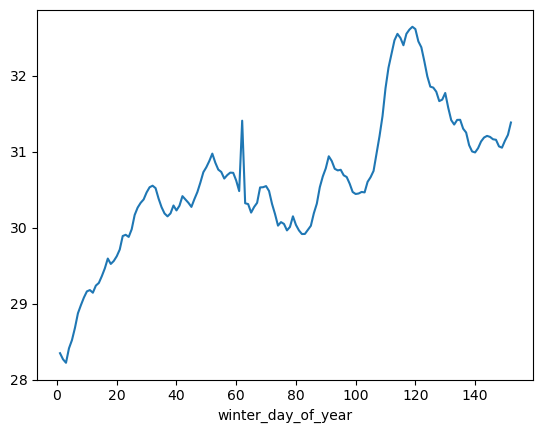

In [15]:
# plot the climatology for demand net wind
climatology_NDJFM["demand_net_wind"].plot()

In [16]:
# apply a 5 day rolling mean to the observed data
obs_df_smooth = obs_df.rolling(window="5D", min_periods=5, center=True).mean()

In [17]:
# subset obs_df_smooth to days of the year in NDJFM
obs_df_smooth_NDJFM_2011 = obs_df_smooth.loc[
    (obs_df_smooth.index >= "2010-11-01") & (obs_df_smooth.index <= "2011-03-31")
]

In [18]:
len(obs_df_smooth_NDJFM_2011.index)

151

In [19]:
len(climatology_NDJFM.index)

152

Text(0, 0.5, 'Demand Net Wind (GW)')

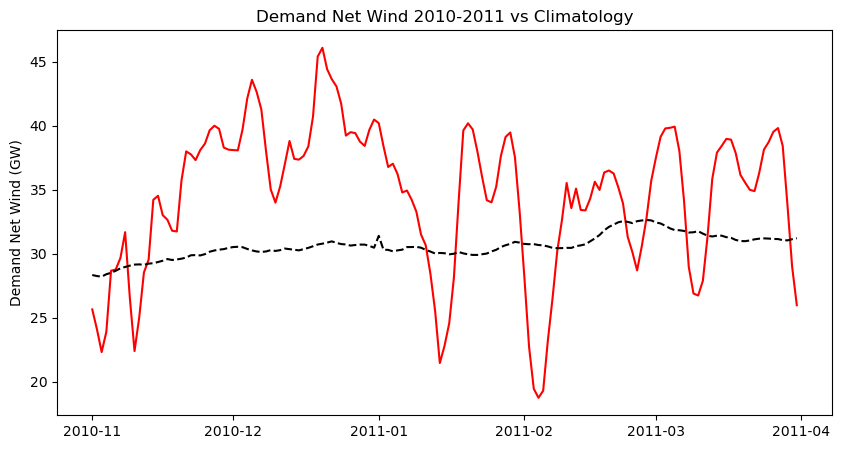

In [20]:
# Plot the demand net wind for 2010 relative to the climatology
# November 2010 -> March 2011
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the period of interest
plt.plot(
    obs_df_smooth_NDJFM_2011.index,
    obs_df_smooth_NDJFM_2011["demand_net_wind"],
    label="2010-2011",
    color="red",
)

# plot the climatology
plt.plot(
    obs_df_smooth_NDJFM_2011.index,
    climatology_NDJFM["demand_net_wind"][:-1],
    label="climatology",
    color="black",
    linestyle="--",
)

# set the title
plt.title("Demand Net Wind 2010-2011 vs Climatology")

# set the x-axis label
plt.ylabel("Demand Net Wind (GW)")

In [21]:
def format_func(
    x: float,
    pos: int,
):
    """
    Formats the x-axis ticks as significant figures.

    Args:
        x (float): The tick value.
        pos (int): The position of the tick.

    Returns:
        str: The formatted tick value.
    """
    return f"{x:.4g}"

def format_func_one_decimal(
    x: float,
    pos: int,
):
    """
    Formats the x-axis ticks to one decimal point.

    Args:
        x (float): The tick value.
        pos (int): The position of the tick.

    Returns:
        str: The formatted tick value.
    """
    return f"{x:.1f}"

# write a function for plotting the full field MSLP data
# for a full period of interest e.g. November 2010 -> March 2011
def plot_mslp_anoms(
    start_date: str,
    end_date: str,
    title: str,
    variable: str = "msl",
    freq: str = "amon",
    lat_bounds: list = [30, 80],
    lon_bounds: list = [-90, 30],
    ERA5_regrid_path: str = "/gws/nopw/j04/canari/users/benhutch/ERA5/global_regrid_sel_region_psl.nc",
    climatology_period: list[int] = [1990, 2020],
    calc_anoms: bool = False,
):
    """
    Grabs the MSLP anomalies for a given period of interest and plots them.

    Args:
        start_date (str): The start date of the period of interest.
        end_date (str): The end date of the period of interest.
        title (str): The title of the plot.
        variable (str): The variable of interest.
        freq (str): The frequency of the data.
        lat_bounds (list): The latitude bounds for the plot.
        lon_bounds (list): The longitude bounds for the plot.
        ERA5_regrid_path (str): The path to the regridded ERA5 data.

    Returns:
        None
    """

    # Load the observed data
    ds = xr.open_mfdataset(
        ERA5_regrid_path,
        chunks={"time": 10},
        combine="by_coords",
        parallel=False,
        engine="netcdf4",
        coords="minimal",
    )

    # If expver is present in the observations
    if "expver" in ds.coords:
        # Combine the first two expver variables
        ds = ds.sel(expver=1).combine_first(ds.sel(expver=5))

    # if the variable is not in the dataset
    if variable not in ds:
        # raise an error
        raise ValueError(f"{variable} not in dataset")

    # calculate the ds climatology
    if calc_anoms:
        # Strip the month from the start and end dates
        # format is "YYYY-MM-DD"
        start_month = start_date[5:7]
        end_month = end_date[5:7]

        # form the list of months to subset the data
        if start_month == end_month:
            months = [start_month]
        elif start_month < end_month:
            months = [
                str(i).zfill(2) for i in range(int(start_month), int(end_month) + 1)
            ]
        else:
            months = [str(i).zfill(2) for i in range(int(start_month), 13)]
            months += [str(i).zfill(2) for i in range(1, int(end_month) + 1)]

        # convert all the months to integers
        months = [int(i) for i in months]

        # print the months
        print(f"months to subset to: {months}")

        # subset the data to the region
        ds_clim = ds.sel(
            lat=slice(lat_bounds[0], lat_bounds[1]),
            lon=slice(lon_bounds[0], lon_bounds[1]),
        )

        # subset the data
        ds_clim = ds_clim.sel(time=ds["time.month"].isin(months))

        # Select the years
        ds_clim = ds_clim.sel(
            time=slice(
                f"{climatology_period[0]}-01-01", f"{climatology_period[1]}-12-31"
            )
        )

        # calculate the climatology
        climatology = ds_clim[variable].mean(dim="time")

    # select the variable
    ds = ds[variable].sel(time=slice(start_date, end_date)).mean(dim="time")

    # subset to the region of interest
    ds = ds.sel(
        lat=slice(lat_bounds[0], lat_bounds[1]), lon=slice(lon_bounds[0], lon_bounds[1])
    )

    # extract the lons
    lons = ds["lon"].values
    lats = ds["lat"].values

    if calc_anoms:
        # calculate the anomalies
        field = (ds.values - climatology.values) / 100  # convert to hPa
    else:
        field = ds.values / 100  # convert to hPa

    # set up the figure
    fig, ax = plt.subplots(
        figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree())
    )

    # if calc_anoms is True
    if calc_anoms:
        # clevs = np.linspace(-8, 8, 18)
        clevs = np.array([
            -8.0,
            -7.0,
            -6.0,
            -5.0,
            -4.0,
            -3.0,
            -2.0,
            -1.0,
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
        ])
        ticks = clevs

        # ensure that these are floats
        clevs = clevs.astype(float)
        ticks = ticks.astype(float)
    else:
        # define the contour levels
        clevs = np.array(np.arange(988, 1024 + 1, 2))
        ticks = clevs

        # ensure that these are ints
        clevs = clevs.astype(int)
        ticks = ticks.astype(int)

    # # print the shape of the inputs
    # print(f"lons shape: {lons.shape}")
    # print(f"lats shape: {lats.shape}")
    # print(f"field shape: {field.shape}")
    # print(f"clevs shape: {clevs.shape}")

    # # print the field values
    # print(f"field values: {field}")

    # Define the custom diverging colormap
    # cs = ["purple", "blue", "lightblue", "lightgreen", "lightyellow", "orange", "red", "darkred"]
    # cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

    # custom colormap
    cs = [
        "#4D65AD",
        "#3E97B7",
        "#6BC4A6",
        "#A4DBA4",
        "#D8F09C",
        "#FFFEBE",
        "#FFD27F",
        "#FCA85F",
        "#F57244",
        "#DD484C",
        "#B51948",
    ]
    # cs = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]
    cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

    # plot the data
    mymap = ax.contourf(
        lons, lats, field, clevs, transform=ccrs.PlateCarree(), cmap=cmap, extend="both"
    )
    contours = ax.contour(
        lons, lats, field, clevs, colors="black", transform=ccrs.PlateCarree(), linewidth=0.2, alpha=0.5
    )
    if calc_anoms:
        ax.clabel(contours, clevs, fmt='%.1f', fontsize=8, inline=True, inline_spacing=0.0)
    else:
        ax.clabel(contours, clevs, fmt='%.4g', fontsize=8, inline=True, inline_spacing=0.0)

    # add coastlines
    ax.coastlines()

    # format the gridlines and labels
    gl = ax.gridlines(
        draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
    )
    gl.xlabels_top = False
    gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {"size": 7, "color": "black"}
    gl.ylabels_right = False
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {"size": 7, "color": "black"}


    if calc_anoms:
        cbar = plt.colorbar(
            mymap,
            orientation="horizontal",
            shrink=0.7,
            pad=0.1,
            format=FuncFormatter(format_func_one_decimal),
        )
        # add colorbar label
        cbar.set_label(f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)", rotation=0, fontsize=10)

        # add contour lines to the colorbar
        cbar.add_lines(contours)
    else:
        # add colorbar
        cbar = plt.colorbar(
            mymap,
            orientation="horizontal",
            shrink=0.7,
            pad=0.1,
            format=FuncFormatter(format_func),
        )
        cbar.set_label("mean sea level pressure (hPa)", rotation=0, fontsize=10)

        # add contour lines to the colorbar
        cbar.add_lines(contours)
    cbar.ax.tick_params(labelsize=7, length=0)
    # set the ticks
    cbar.set_ticks(ticks)

    # add title
    ax.set_title(title, fontsize=12, weight='bold')

    # make plot look nice
    plt.tight_layout()

    # save figure to file
    # plt.savefig('../images/8_python_simple_map_plot_sst_anoms_300dpi.png',
    # format='png', dpi=300)

    # plt.close()

    return None

/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


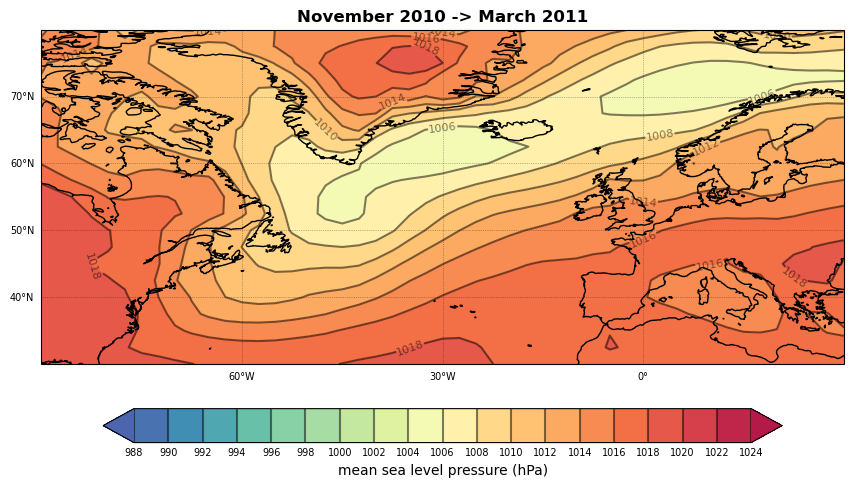

In [22]:
# test the function
plot_mslp_anoms(
    start_date="2010-11-01",
    end_date="2011-03-31",
    title="November 2010 -> March 2011",
    calc_anoms=False,
)

In [23]:
import plotting_functions
from plotting_functions import plot_mslp_anoms_temp_wind_obs

In [24]:
importlib.reload(plotting_functions)

<module 'plotting_functions' from '/home/users/benhutch/unseen_multi_year/plotting_functions.py'>

months to subset to: [11, 12, 1, 2, 3]
len of clevs_psl: 16
len of clevs_var: 20
field_var shape: (21, 49)
field_psl shape: (21, 49)
field_var values: [[-0.3565979  -0.39120483 -0.55978394 ... -0.68566895 -0.7455139
  -0.67248535]
 [-0.59436035 -0.71765137 -0.708313   ... -0.36462402 -0.24511719
  -0.146698  ]
 [-1.059082   -0.9836426  -0.6618347  ... -0.7649231   0.04522705
  -0.05023193]
 ...
 [ 1.0442047   1.1096344   2.0296478  ... -1.7656555  -1.9876404
  -2.0952454 ]
 [-1.2959442   1.3174133   2.1714935  ... -4.678009   -3.6669006
  -2.7358704 ]
 [ 0.06175232 -0.74961853  0.46769714 ... -7.1545563  -7.6239777
  -7.0018463 ]]
field_psl values: [[-0.23757812 -0.20773438 -0.16296875 ... -1.5066407  -1.3564844
  -1.3026563 ]
 [-0.09117188 -0.07257812 -0.09390625 ... -1.574375   -1.5045313
  -1.3966407 ]
 [-0.03882812 -0.0865625  -0.20296875 ... -1.5829687  -1.5442188
  -1.3757813 ]
 ...
 [ 1.8945312   2.051953    2.229453   ...  0.6785156   0.6596094
   0.68359375]
 [ 2.355547    2.3

/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


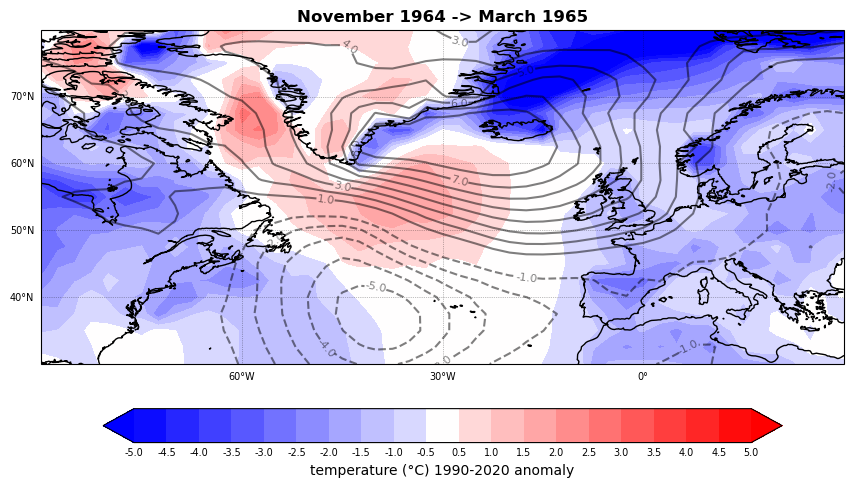

In [25]:
# default is t2m
plot_mslp_anoms_temp_wind_obs(
    start_date="1964-11-01",
    end_date="1965-03-31",
    title="November 1964 -> March 1965",
    variable="t2m",
    calc_anoms=True,
)

months to subset to: [11, 12, 1, 2, 3]
len of clevs_psl: 16
len of clevs_var: 14
field_var shape: (21, 49)
field_psl shape: (21, 49)
field_var values: [[ 0.14865208  0.10439825  0.04114795 ... -0.10879207 -0.19659328
  -0.03887939]
 [ 0.07692099  0.04863048  0.09482479 ...  0.01853943 -0.10482359
   0.10592794]
 [ 0.08031654  0.01988626  0.02366614 ... -0.01291895  0.08741236
   0.41439962]
 ...
 [ 0.34034634  0.29357576 -0.06489182 ...  0.1702652  -0.1440506
  -0.25142002]
 [ 0.6042948   0.34174275  0.34265685 ...  0.23749352  0.30722904
   0.28650856]
 [-0.30132008 -0.13191879  0.10457969 ... -0.08989954  0.05724382
  -0.1721754 ]]
field_psl values: [[-0.23757812 -0.20773438 -0.16296875 ... -1.5066407  -1.3564844
  -1.3026563 ]
 [-0.09117188 -0.07257812 -0.09390625 ... -1.574375   -1.5045313
  -1.3966407 ]
 [-0.03882812 -0.0865625  -0.20296875 ... -1.5829687  -1.5442188
  -1.3757813 ]
 ...
 [ 1.8945312   2.051953    2.229453   ...  0.6785156   0.6596094
   0.68359375]
 [ 2.355547    

/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


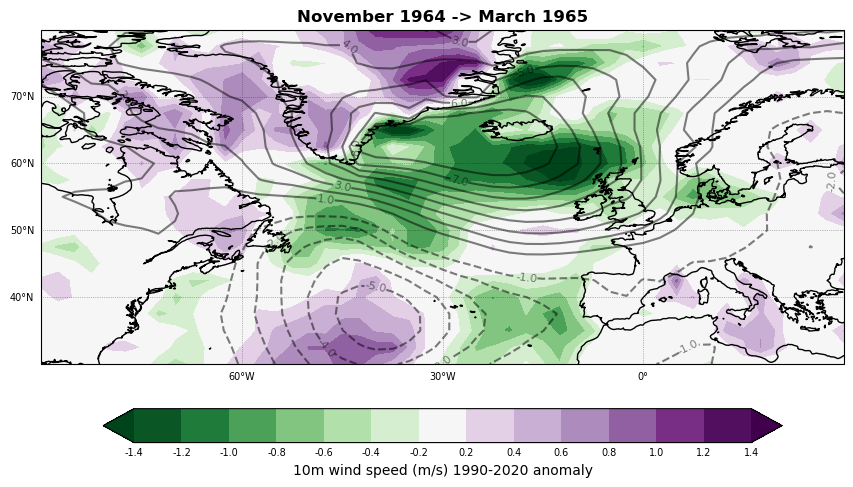

In [26]:
# default is t2m
plot_mslp_anoms_temp_wind_obs(
    start_date="1964-11-01",
    end_date="1965-03-31",
    title="November 1964 -> March 1965",
    variable="si10",
    calc_anoms=True,
)

months to subset to: [11, 12, 1, 2, 3]


/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


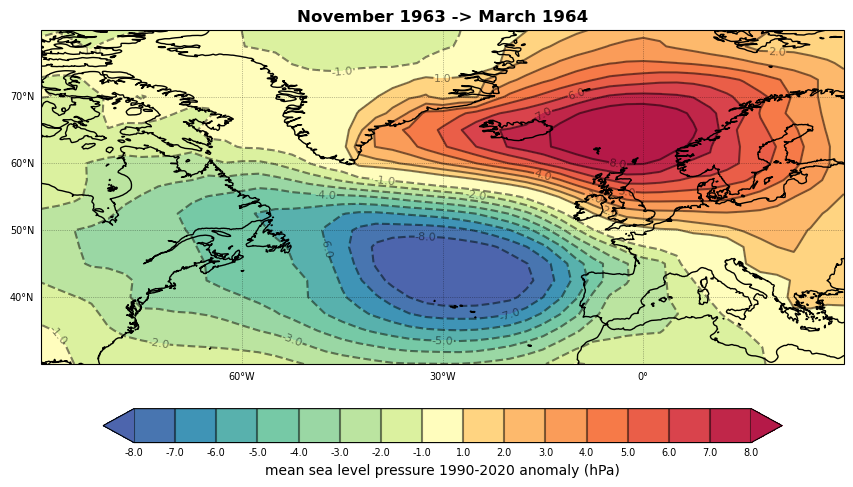

In [27]:
# 1963 was also bad
plot_mslp_anoms(
    start_date="1963-11-01",
    end_date="1964-03-31",
    title="November 1963 -> March 1964",
    calc_anoms=True,
)

months to subset to: [11, 12, 1, 2, 3]


/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


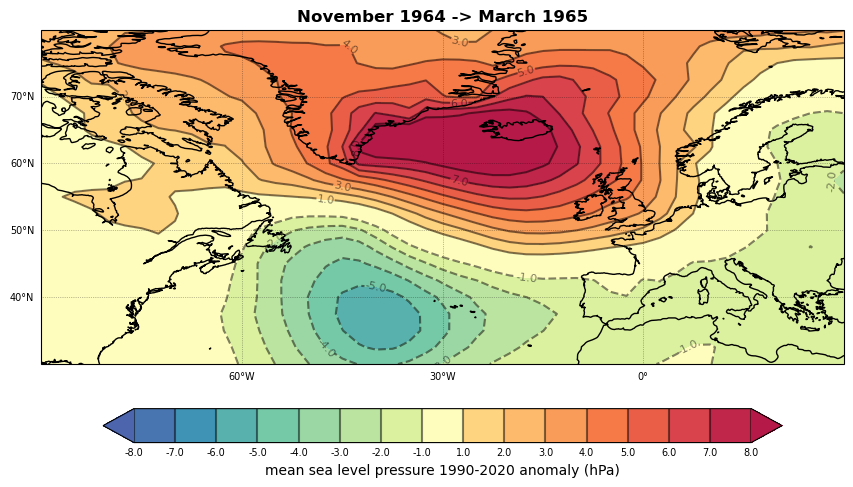

In [28]:
# 1964 to 1965 was also bad
plot_mslp_anoms(
    start_date="1964-11-01",
    end_date="1965-03-31",
    title="November 1964 -> March 1965",
    calc_anoms=True,
)

## Synoptic outlook for model data ##

Do the same but using the HadGEM3-GC31-MM MSLP data instead. Can plot with daily or monthly data.

Maybe use monthly for anomalies?

In [29]:
import plotting_functions
from plotting_functions import plot_mslp_anoms_model

In [30]:
importlib.reload(plotting_functions)

<module 'plotting_functions' from '/home/users/benhutch/unseen_multi_year/plotting_functions.py'>

In [31]:
from plotting_functions import plot_mslp_anoms_model, plot_mslp_var_model

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'sfcWind'
  warnings.warn(
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(


start year: 1963
end year: 1964
model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
variable: sfcWind
frequency: Amon
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files/sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i*_*_1963??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files/sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i1p1f2_gn_196311-197403.nc
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i*_*_1963??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i1_gn_196311-197403.nc
Caculating the climatology for the model data


100%|██████████| 31/31 [00:15<00:00,  2.06it/s]
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
100%|██████████| 31/31 [00:00<00:00, 67.20it/s]
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


len of clevs_psl: 16
len of clevs_var: 14
field_var shape: (21, 49)
field_psl shape: (21, 49)
field_var values: [[0.20618300284108848 0.4890988965188301 0.42840055035006586 ...
  0.04290798248783201 -0.15433979495879147 0.03926807526619225]
 [0.05531389636378137 0.18144482028099818 0.2825310030291157 ...
  -0.0992657076927923 -0.1424494281891855 -0.055418032984579924]
 [-0.03651947359884922 0.09146851878012363 0.019635568126555203 ...
  0.03736451364332627 0.1595261296918311 0.2839176301033266]
 ...
 [-0.1669522685389364 -0.01976213070654098 0.02866700387770127 ...
  -0.3907149776335679 -0.22470312426167105 -0.2178877676686941]
 [0.037522286753500556 0.08917191566959515 0.15924977410224184 ...
  -0.4031867457974343 -0.3516683486200147 -0.21371846045217247]
 [-0.03240946492841168 0.040488840687659566 -0.01716071174990741 ...
  -0.15246601412373195 -0.07519408195249522 -0.06007437244538316]]
field_psl values: [[-0.43613558467739494 -0.4516920362903329 -0.3659238911290595 ...
  -0.5545841

/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


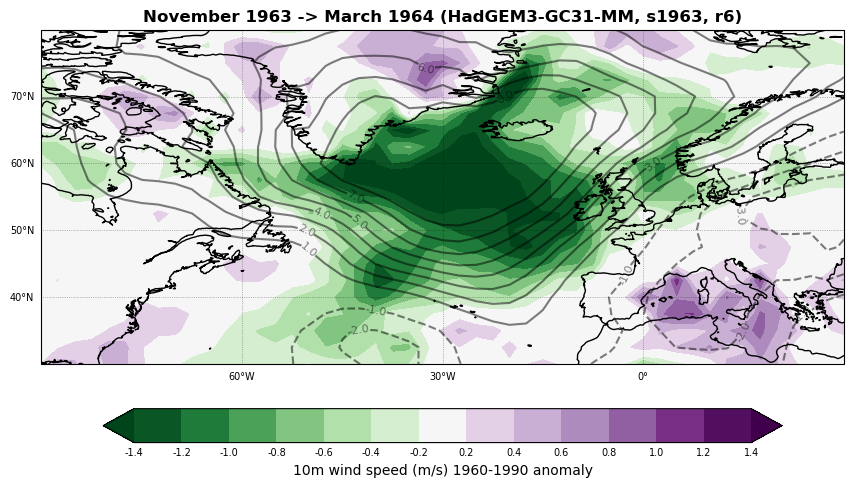

In [33]:
# test the new function
plot_mslp_var_model(
    start_date="1963-11-01",
    end_date="1964-03-30",
    member="6",
    title="November 1963 -> March 1964 (HadGEM3-GC31-MM, s1963, r6)",
    sf_variable="sfcWind",
    calc_anoms=True,
)

model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
variable: psl
frequency: Amon
Model path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM
Model path root: gws
start year: 1965
end year: 1966
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1965-r2i*_*_1965??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1965-r2i1_gn_196511-197603.nc


/home/users/benhutch/.local/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


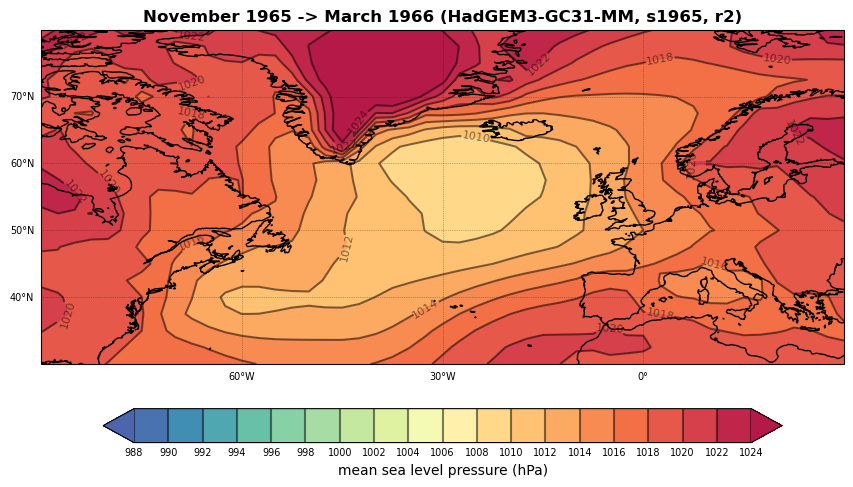

In [32]:
# test the function
plot_mslp_anoms_model(
    start_date="1965-11-01",
    end_date="1966-03-30",
    member="2",
    title="November 1965 -> March 1966 (HadGEM3-GC31-MM, s1965, r2)",
    calc_anoms=False,
)

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(


model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
variable: psl
frequency: Amon
Model path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM
Model path root: gws
start year: 1965
end year: 1966
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1965-r2i*_*_1965??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1965-r2i1_gn_196511-197603.nc
Caculating the climatology for the model data


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:14<00:00,  2.12it/s]
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right a

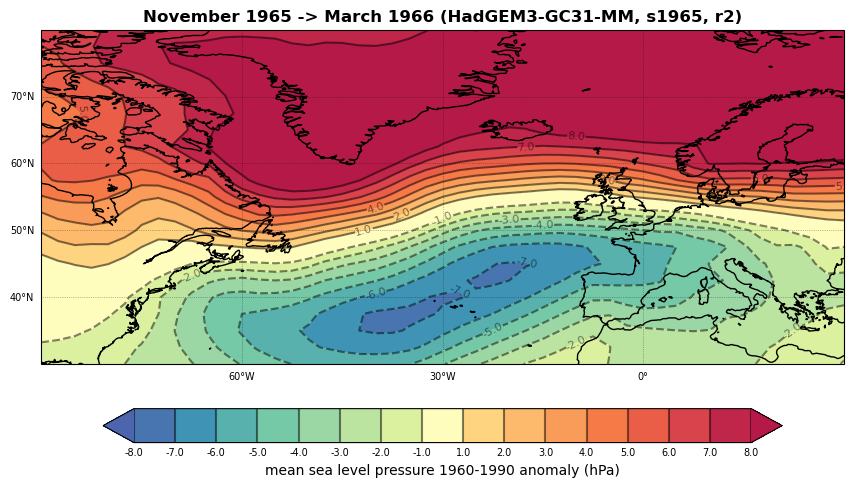

In [33]:
# test the function
plot_mslp_anoms_model(
    start_date="1965-11-01",
    end_date="1966-03-30",
    member="2",
    title="November 1965 -> March 1966 (HadGEM3-GC31-MM, s1965, r2)",
    calc_anoms=True,
)

In [ ]:
import dictionaries_umy as dicts_umy

In [ ]:
# extract the 1th event
event = dicts_umy.model_dnw_purple_events[1]

model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
variable: psl
frequency: Amon
Model path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM
Model path root: gws
start year: 1963
end year: 1964
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i*_*_1963??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i1_gn_196311-197403.nc


/home/users/benhutch/.local/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


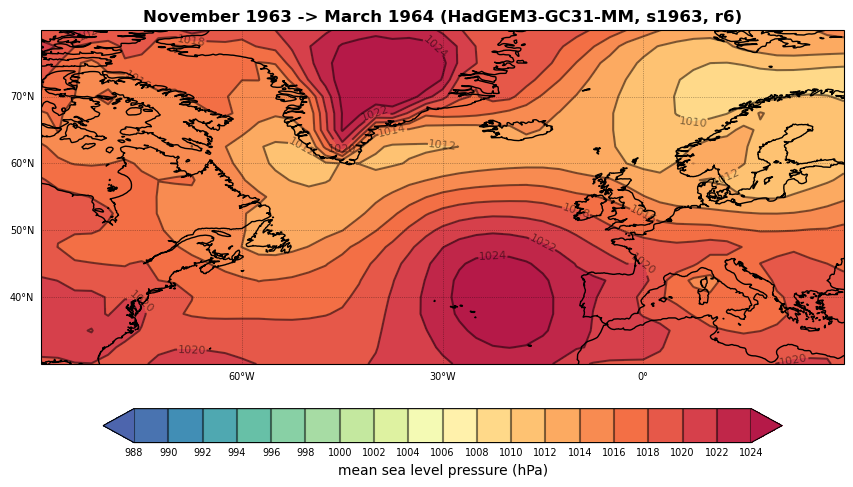

In [ ]:
# plot the absolute values for this event
plot_mslp_anoms_model(
    start_date=event["start_date"],
    end_date=event["end_date"],
    member=event["member"],
    title="November 1963 -> March 1964 (HadGEM3-GC31-MM, s1963, r6)",
    calc_anoms=False,
)

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(


model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
variable: psl
frequency: Amon
Model path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM
Model path root: gws
start year: 1963
end year: 1964
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i*_*_1963??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i1_gn_196311-197403.nc
Caculating the climatology for the model data


100%|██████████| 31/31 [00:08<00:00,  3.57it/s]
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right a

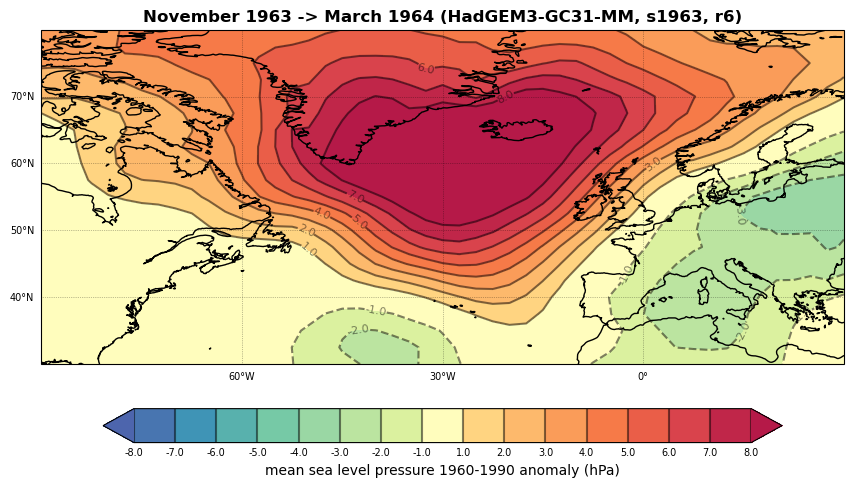

In [ ]:
# Now plot the anomalies
plot_mslp_anoms_model(
    start_date=event["start_date"],
    end_date=event["end_date"],
    member=event["member"],
    title="November 1963 -> March 1964 (HadGEM3-GC31-MM, s1963, r6)",
    calc_anoms=True,
)